# ***Stochastic Inventory Uncapacitated Lot-Sizing Problem with Backlogging***

### READ FILE


In [1]:
import numpy as np
import pandas as pd

class ProductionData:
    def __init__(self, demand_forecast, setup_cost, production_cost, holding_cost, backlogging_cost, num_periods):
        self.demand_forecast = np.array(demand_forecast)
        self.setup_cost = np.array(setup_cost)
        self.production_cost = np.array(production_cost)
        self.holding_cost = np.array(holding_cost)
        self.backlogging_cost = np.array(backlogging_cost)
        self.num_periods = num_periods
    
    def __repr__(self):
        return (f"ProductionData(\n"
                f"  Demand Forecast: {self.demand_forecast}\n"
                f"  Setup Cost: {self.setup_cost}\n"
                f"  Production Cost: {self.production_cost}\n"
                f"  Holding Cost: {self.holding_cost}\n"
                f"  backlogging cost: {self.backlogging_cost}\n"
                f"  Number of Periods: {self.num_periods}\n")

def read_production_data(file_path, sheet_name):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    # Insert dummy period 0
    demand_forecast = np.insert(df["Demand Forecast"].to_numpy(), 0, 0)
    setup_cost = np.insert(df["Setup Cost"].to_numpy(), 0, 0)
    production_cost = np.insert(df["Production cost"].to_numpy(), 0, 0)
    holding_cost = np.insert(df["Holding cost"].to_numpy(), 0, 0)
    backlogging_cost = np.insert(df["Backlogging cost"].to_numpy(), 0, 0)
    
    num_periods = df.shape[0]
    
    return ProductionData(demand_forecast, setup_cost, production_cost, holding_cost, backlogging_cost, num_periods)

# Define file path and sheet names
file_path = "ULSP-instancesR.xlsx"
sheet_list = ["6-periods (1)", "6-periods (2)", "12-periods (1)", "12-periods (2)", 
              "24-periods (1)", "24-periods (2)", "52-periods (1)", "52-periods (2)", 
              "104-periods (1)", "104-periods (2)"]



In [6]:
import gurobipy as gp
from gurobipy import GRB, quicksum
import pandas as pd
import numpy as np

# DataFrame to store all results
results_df = pd.DataFrame(columns=["Sheet", "Period", "y", "x", "S", "b"])

# Process each sheet
for sheet_name in sheet_list:
    print(f"\nProcessing sheet: {sheet_name}")

    # Read data using the function
    data = read_production_data(file_path, sheet_name)

    T = data.num_periods
    print(f"Number of periods: {T}")

    # Create Gurobi model
    model = gp.Model("Uncapacitated Lot-Sizing Problem")

    # Decision variables
    y = model.addVars(T+1, vtype=GRB.BINARY, name="y")  
    x = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="x")  
    S = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="S")  
    b = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="b")  # Amount backlogged at the end of period t

    # Objective function
    model.setObjective(
        quicksum(data.setup_cost[t] * y[t] for t in range(1, T+1)) +
        quicksum(data.production_cost[t] * x[t] for t in range(1, T+1)) +
        quicksum(data.holding_cost[t] * S[t] for t in range(1, T+1)) +
        quicksum(data.backlogging_cost[t] * b[t] for t in range(1, T+1)),  # backlogging cost
        GRB.MINIMIZE
    )

    # Constraints
    model.addConstr(S[0] == 0, name="no_inventory0") 
    model.addConstr(S[T] == 0, name="no_inventoryT")  
    model.addConstr(b[0] == 0, name="no_backlogging0") 
    model.addConstr(b[T] == 0, name="no_backloggingT") 

    # constraints
    for t in range(1, T+1):
        model.addConstr(x[t] + S[t-1] - b[t-1] == data.demand_forecast[t] + S[t] - b[t], name=f"demand_satisfied_{t}")
        model.addConstr(x[t] <= (quicksum(data.demand_forecast[m] for m in range(t, T+1)) + b[t-1]) * y[t], name=f"setup_constraint_{t}")

    # Solve model
    model.optimize()

    # Check if the model found an optimal solution
    if model.status == GRB.OPTIMAL:
        print("\nOptimal solution found:")
        # Create a temporary DataFrame for the current sheet results
        sheet_results = pd.DataFrame(columns=["Sheet", "Period", "y", "x", "S", "b"])
        for t in range(1, T+1):
            # Store the results for the current sheet
            sheet_results = pd.concat([sheet_results, pd.DataFrame([{
                "Sheet": sheet_name,
                "Period": t,
                "y": y[t].X,
                "x": x[t].X,
                "S": S[t].X,
                "b": b[t].X
            }])], ignore_index=True)
        
        # Concatenate the results for all sheets
        results_df = pd.concat([results_df, sheet_results], ignore_index=True)

    else:
        print(f"No optimal solution found for sheet {sheet_name}.")

# Save results to a CSV file
results_df.to_csv("optimization_results.csv", index=False)
print("\nResults have been saved to 'optimization_results.csv'.")



Processing sheet: 6-periods (1)
Number of periods: 6
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Optimize a model with 10 rows, 28 columns and 34 nonzeros
Model fingerprint: 0x38a97cbc
Model has 6 quadratic constraints
Variable types: 21 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 2e+03]
  Objective range  [3e+00, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 6e+02]
Presolve removed 3 rows and 6 columns
Presolve time: 0.00s
Presolved: 22 rows, 37 columns, 68 nonzeros
Presolved model has 10 SOS constraint(s)
Variable types: 26 continuous, 11 integer (11 binary)
Found heuristic

C:\Users\irako\AppData\Local\Temp\ipykernel_18040\627824904.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{
C:\Users\irako\AppData\Local\Temp\ipykernel_18040\627824904.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, sheet_results], ignore_index=True)


Root relaxation: objective 1.016860e+05, 16 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    101686.00000 101686.000  0.00%     -    0s

Explored 1 nodes (16 simplex iterations) in 0.13 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 101686 140370 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.016860000000e+05, best bound 1.016860000000e+05, gap 0.0000%

Optimal solution found:

Processing sheet: 12-periods (1)
Number of periods: 12
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2560044 - for non-commercial use only - registered to vi___@uge

C:\Users\irako\AppData\Local\Temp\ipykernel_18040\627824904.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{
C:\Users\irako\AppData\Local\Temp\ipykernel_18040\627824904.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{


Number of periods: 12
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Optimize a model with 16 rows, 52 columns and 64 nonzeros
Model fingerprint: 0x2968c9fc
Model has 12 quadratic constraints
Variable types: 39 continuous, 13 integer (13 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 6e+03]
  Objective range  [2e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+01, 1e+03]
Presolve removed 3 rows and 6 columns
Presolve time: 0.00s
Presolved: 46 rows, 79 columns, 146 nonzeros
Presolved model has 22 SOS constraint(s)
Variable types: 56 continuous, 23 integer (23 binary)
Found heuristic solution: objective 185742.

C:\Users\irako\AppData\Local\Temp\ipykernel_18040\627824904.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{
C:\Users\irako\AppData\Local\Temp\ipykernel_18040\627824904.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{


Number of periods: 24
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Optimize a model with 28 rows, 100 columns and 124 nonzeros
Model fingerprint: 0x96f24e7f
Model has 24 quadratic constraints
Variable types: 75 continuous, 25 integer (25 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+04]
  Objective range  [1e+00, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 9e+02]
Presolve removed 3 rows and 6 columns
Presolve time: 0.00s
Presolved: 94 rows, 163 columns, 302 nonzeros
Presolved model has 46 SOS constraint(s)
Variable types: 116 continuous, 47 integer (47 binary)
Found heuristic solution: objective 756

C:\Users\irako\AppData\Local\Temp\ipykernel_18040\627824904.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{


     0     0 182757.703    0   87 266080.000 182757.703  31.3%     -    0s
     0     0 182757.703    0   37 266080.000 182757.703  31.3%     -    0s
H    0     0                    265346.00000 182757.703  31.1%     -    0s
     0     0 182757.703    0   29 265346.000 182757.703  31.1%     -    0s
     0     0 183742.231    0   29 265346.000 183742.231  30.8%     -    0s
     0     0 184376.531    0   30 265346.000 184376.531  30.5%     -    0s
     0     0 189436.559    0   27 265346.000 189436.559  28.6%     -    0s
H    0     0                    260994.00000 189436.559  27.4%     -    0s
     0     0 190089.537    0   27 260994.000 190089.537  27.2%     -    0s
H    0     0                    222665.00000 190253.690  14.6%     -    0s
H    0     0                    213971.00000 190253.690  11.1%     -    0s
     0     2 190253.690    0   27 213971.000 190253.690  11.1%     -    0s
H  103    90                    212525.51570 193941.497  8.74%   3.5    0s
*  104    90             

C:\Users\irako\AppData\Local\Temp\ipykernel_18040\627824904.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Optimize a model with 56 rows, 212 columns and 264 nonzeros
Model fingerprint: 0xfafc8413
Model has 52 quadratic constraints
Variable types: 159 continuous, 53 integer (53 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 2e+04]
  Objective range  [1e+00, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 1e+03]
Presolve removed 3 rows and 6 columns
Presolve time: 0.00s
Presolved: 206 rows, 359 columns, 666 nonzeros
Presolved model has 102 SOS constraint(s)
Variable types: 256 continuous, 103 integer (103 binary)
Found heuristic solution: objective 2373892.0099

Root r

C:\Users\irako\AppData\Local\Temp\ipykernel_18040\627824904.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{



    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 223322.357    0  166 3915471.01 223322.357  94.3%     -    0s
     0     0 306427.082    0   91 3915471.01 306427.082  92.2%     -    0s
H    0     0                    530541.00000 307508.952  42.0%     -    0s
H    0     0                    524173.00000 307508.952  41.3%     -    0s
     0     0 313573.617    0  119 524173.000 313573.617  40.2%     -    0s
H    0     0                    463592.00000 313726.963  32.3%     -    0s
H    0     0                    463442.00000 313726.963  32.3%     -    0s
     0     0 314375.134    0  119 463442.000 314375.134  32.2%     -    0s
H    0     0                    413114.00000 314375.134  23.9%     -    0s
H    0     0                    407594.00000 314375.134  22.9%     -    0s
     0     0 318887.914    0   84 407594.000 318887.914  21.8%     -    0s
     0     0 319341.746

C:\Users\irako\AppData\Local\Temp\ipykernel_18040\627824904.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{


Found heuristic solution: objective 6820037.0147

Root relaxation: objective 3.993129e+05, 467 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 399312.901    0  143 6820037.01 399312.901  94.1%     -    0s
     0     0 504353.299    0  125 6820037.01 504353.299  92.6%     -    0s
H    0     0                    1838121.0000 507206.134  72.4%     -    0s
H    0     0                    1574973.0000 507206.134  67.8%     -    0s
H    0     0                    1466521.0000 507206.134  65.4%     -    0s
     0     0 507206.134    0  126 1466521.00 507206.134  65.4%     -    0s
     0     0 521986.401    0  164 1466521.00 521986.401  64.4%     -    0s
     0     0 522721.161    0  164 1466521.00 522721.161  64.4%     -    0s
     0     2 524591.038    0  164 1466521.00 524591.038  64.2%     -    0s
H   41    52                    141

C:\Users\irako\AppData\Local\Temp\ipykernel_18040\627824904.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{


## 10.1 Pattern Observation in MILP

Observation; It is unprofitable to both hold stock and backlog in the same period, thus b and S cannot be positive at the same time. Thus S > 0 means b = 0 and vice versa.  Several properties of an optimal flow immediately follow from the fact that an extreme flow can have at most one positive input at any node. These properties are:

*   I+t1 > 0 implies xi = 0,
*   xi > 0 implies I- = 0, and
*   I+ 1 > 0 implies I- = 0.


Blablabla :  PROPERTY: between any two periods in which production is completed, there is a regeneration point, ie. where S = 0

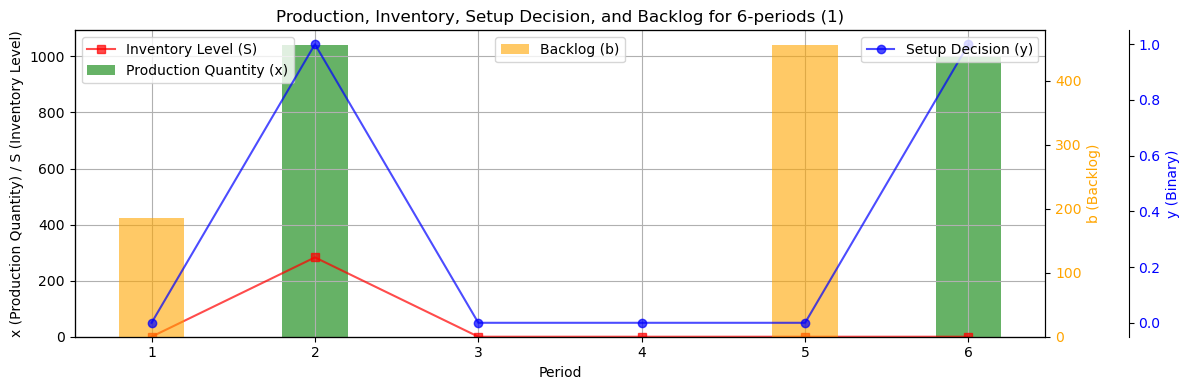

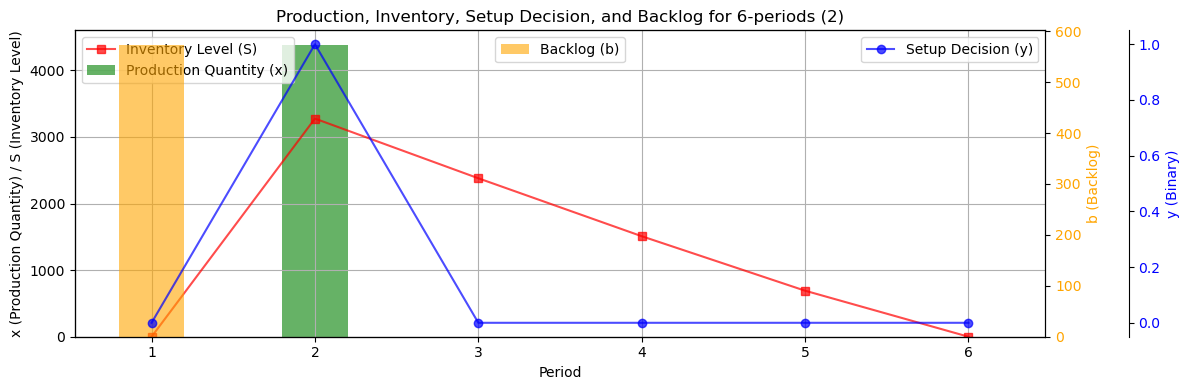

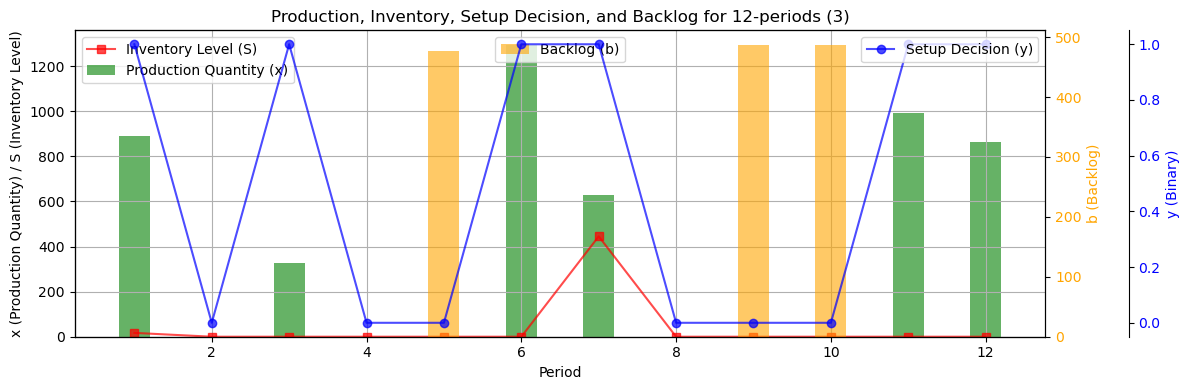

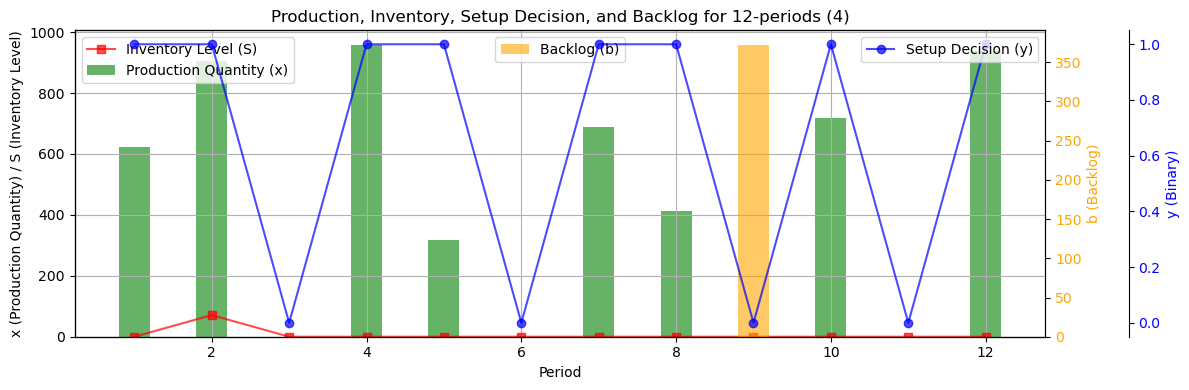

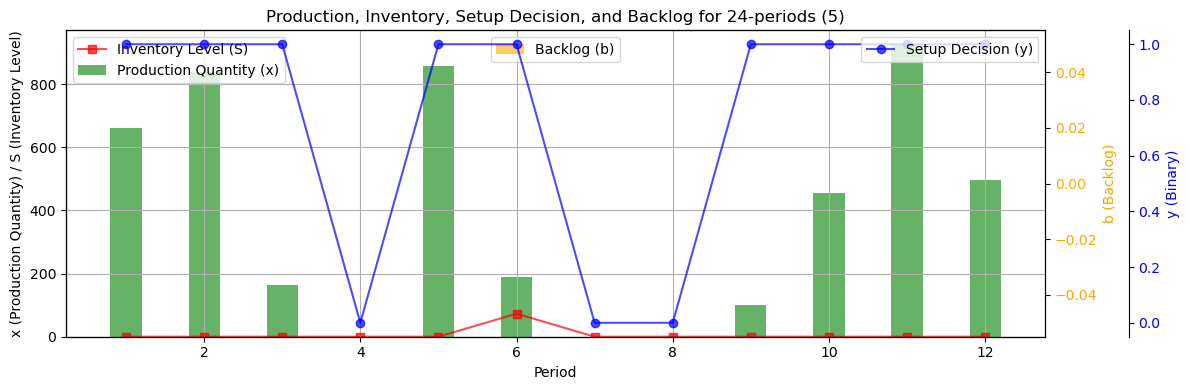

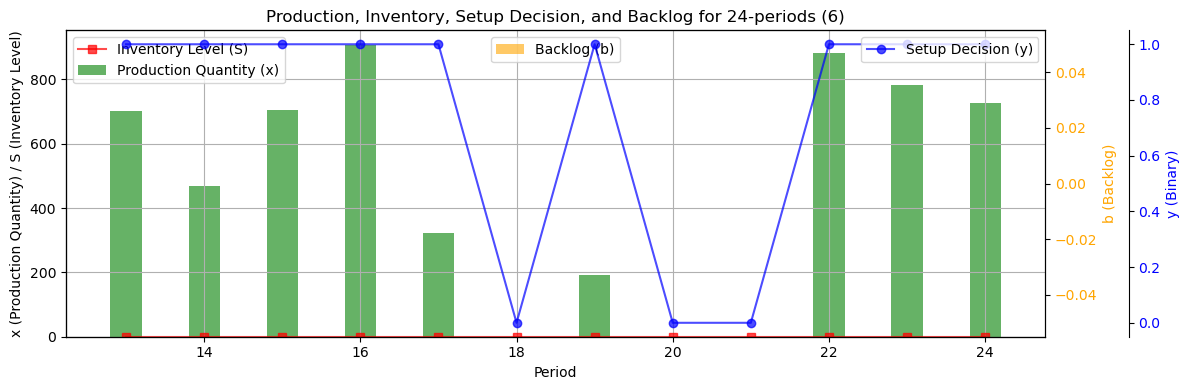

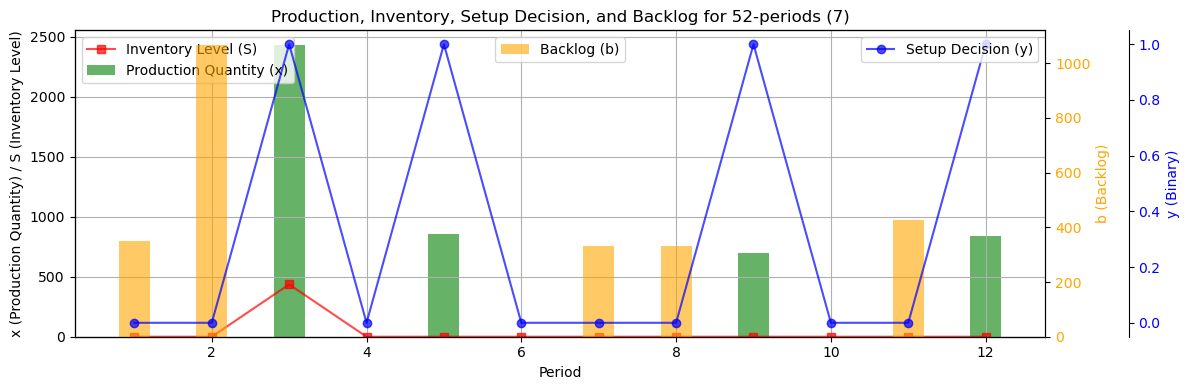

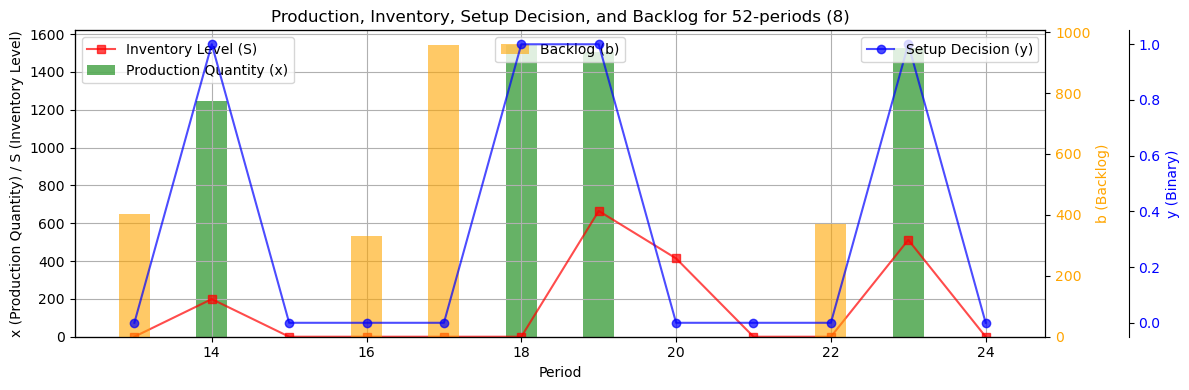

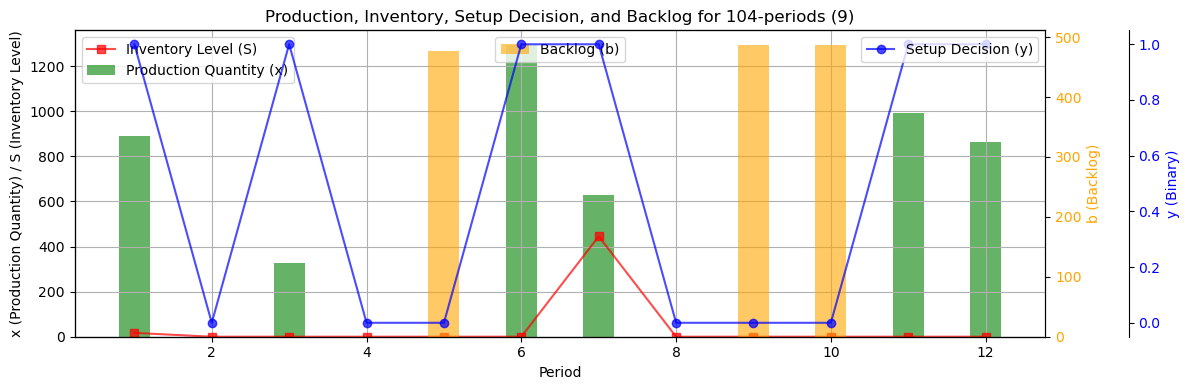

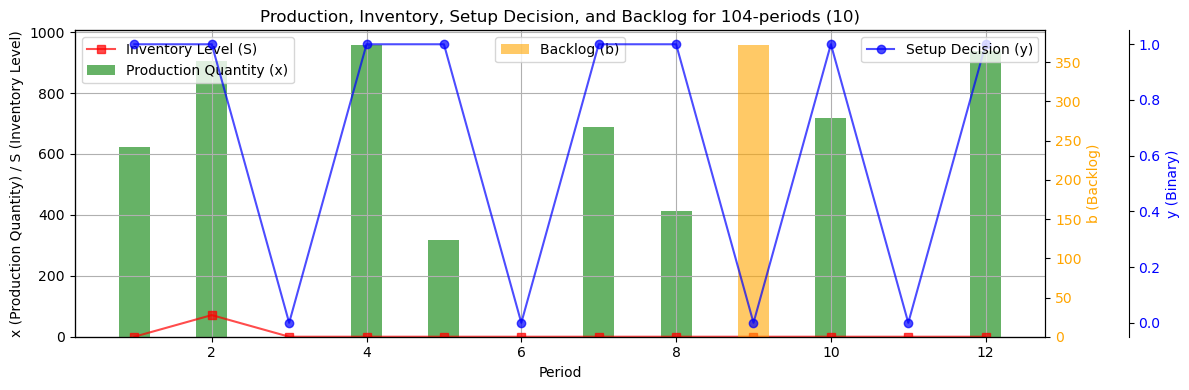

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the all_results CSV file into a DataFrame
results_df = pd.read_csv("optimization_results.csv")

# Define function to plot data
def plot_data(data, sheet_name):
    fig, ax1 = plt.subplots(figsize=(12, 4))
    
    # Plot production quantity (x) as a bar chart
    ax1.bar(data['Period'], data['x'], color='g', width=0.4, label='Production Quantity (x)', alpha=0.6)
    
    # Plot inventory level (S) as a red line
    ax1.plot(data['Period'], data['S'], marker='s', linestyle='-', color='r', label='Inventory Level (S)', alpha=0.7)
    
    ax1.set_xlabel('Period')
    ax1.set_ylabel('x (Production Quantity) / S (Inventory Level)')
    ax1.tick_params(axis='y')

    # Create a second y-axis for backlog (b)
    ax2 = ax1.twinx()
    
    # Plot backlog (b) as a yellow block (bar)
    ax2.bar(data['Period'], data['b'], color='orange', label='Backlog (b)', alpha=0.6, width=0.4)
    ax2.set_ylabel('b (Backlog)', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Create a third y-axis for setup decision (y)
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Shift the third axis to avoid overlap
    
    # Plot setup decision (y) as a blue line
    ax3.plot(data['Period'], data['y'], marker='o', linestyle='-', color='b', label='Setup Decision (y)', alpha=0.7)
    ax3.set_ylabel('y (Binary)', color='b')
    ax3.tick_params(axis='y', labelcolor='b')

    plt.title(f'Production, Inventory, Setup Decision, and Backlog for {sheet_name}')
    ax1.grid(True)
    
    # Adding legends for all three y-axes
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper center')
    ax3.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Split the CSV into instances
sheet_ranges = [
    ("6-periods (1)", 0, 6),
    ("6-periods (2)", 6, 12),
    ("12-periods (3)", 12, 24),
    ("12-periods (4)", 24, 36)
]

for sheet_name, start_row, end_row in sheet_ranges:
    sheet_data = results_df.iloc[start_row:end_row]
    plot_data(sheet_data, sheet_name)


## 10.2 Zangwill

In [8]:
def zangwill(demand, setup_costs, holding_costs, unit_costs, backlogging_costs, num_periods):

  T = num_periods  # Number of periods

  #DP tables for a and b
  A = np.full(T+1, float('inf'))
  B = np.full((T+1, T+1), float('inf'))
  Betas = np.zeros(T)
  Gammas = np.zeros(T)

  #base cases:
  A[T] = 0
  for epsilon in range(T+1):
    B[T][epsilon] = 0


  #first calculate b_T
  beta = T
  for epsilon in range(0, T):
      b_min = float('inf') #set the bar
      for gamma in range(T, T+1):

        b = (setup_costs[beta])

        b += unit_costs[beta] * sum(demand[beta-epsilon:gamma+1])

        b += sum(holding_costs[k] * sum(demand[k+1:gamma+1]) for k in range(beta, gamma))

        b += A[gamma]

        if b < b_min:
          b_min = b
          gamma_optimal = gamma

      #storage
      B[beta-1][epsilon] = b_min
      Gammas[beta-1] = gamma_optimal

  #backwards recursion through periods
  for t in range(T-1, -1, -1):


    #first we do a_t
    alpha = t #for clarity
    a_min = float('inf') #set the bar
    for beta in range(alpha+1, T+1):
      a = sum(backlogging_costs[k] * sum(demand[alpha+1:k+1]) for k in range(alpha+1, beta)) + B[beta-1][beta-alpha-1]
      if a <= a_min:
        a_min = a
        beta_optimal = beta
    #storage of optimal values
    A[alpha] = a_min
    Betas[alpha] = beta_optimal

    #now we do b_t
    beta = t
    for epsilon in range(0, beta):
      b_min = float('inf') #set the bar
      for gamma in range(beta, T+1):

        b = (setup_costs[beta])


        b += unit_costs[beta] * sum(demand[beta-epsilon:gamma+1])


        b += sum(holding_costs[k] * sum(demand[k+1:gamma+1]) for k in range(beta, gamma))

        b += A[gamma]

        #print(f'Setup Costs: { (setup_costs[beta])}')
        #print('Production Costs:', unit_costs[beta] * sum(demand[beta-epsilon:gamma+1]))
        #print('Holding Costs:', sum(holding_costs[k] * sum(demand[k+1:gamma+1]) for k in range(beta, gamma)))
        #print('Alfa Costs:', A[gamma])
        #print('b:', b)

        if b <= b_min:
          b_min = b
          gamma_optimal = gamma

      #storage
      B[beta-1][epsilon] = b_min
      Gammas[beta-1] = gamma_optimal
      #print('Gammas:', Gammas)


  return A[0], Betas, Gammas


def schedule_backlog(Betas, Gammas):
  N = len(Betas)
  t = 0

  while t <= N-1:
    t = int(Betas[t])
    print(f"Production in period { t}")
    t = int(Gammas[t-1])
    print(f"Regeneration in period { t}")

for sheet_name in sheet_list:
    print(f"\nProcessing sheet: {sheet_name}")

    # Read the Excel file from the specific sheet
    data=read_production_data(file_path, sheet_name)
    print(data)
    #print(data.demand_forecast[0])
    #print(data.holding_cost[0])

    min_cost, Betas, Gammas = zangwill(data.demand_forecast, data.setup_cost, data.holding_cost, data.production_cost, data.backlogging_cost, data.num_periods)
   # print(Betas)
    #print(Gammas)
    #print("Optimal order schedule:", optimal_orders)
    print("Minimum total cost:", min_cost)
    schedule_backlog(Betas, Gammas)


Processing sheet: 6-periods (1)
ProductionData(
  Demand Forecast: [  0 185 573 283   0 456 542]
  Setup Cost: [   0 2016 4377  817 2133 2572 1381]
  Production Cost: [  0 107  11  81 181  91   8]
  Holding Cost: [0 6 6 6 3 3 6]
  backlogging cost: [0 4 5 3 4 5 4]
  Number of Periods: 6

Minimum total cost: 29911.0
Production in period 2
Regeneration in period 4
Production in period 6
Regeneration in period 6

Processing sheet: 6-periods (2)
ProductionData(
  Demand Forecast: [  0 573 533 896 870 818 691]
  Setup Cost: [   0 1101 2789 4787 3406 3691 2724]
  Production Cost: [  0  21  14  85 140 178 144]
  Holding Cost: [0 3 7 3 2 4 3]
  backlogging cost: [0 3 3 4 5 5 5]
  Number of Periods: 6

Minimum total cost: 101686.0
Production in period 2
Regeneration in period 6

Processing sheet: 12-periods (1)
ProductionData(
  Demand Forecast: [  0 875  17 325   0 477 817 182 445 487   0 506 863]
  Setup Cost: [   0 2059 4342 1447 1889 1577 3605 2584 3825 1944  963 2903  508]
  Production Co